In [1]:
import os
import sys

In [2]:
%pylab inline
import glob, tqdm
from scipy.stats import multivariate_normal

Populating the interactive namespace from numpy and matplotlib


In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors, cm
import matplotlib.colors as mcolors
from IPython.display import HTML

In [4]:
cwd = os.getcwd()
cwd

'/data/SBI/GenericHopf_SBI_GenericSC'

In [5]:
Res_dir='Res_generative_connectome'

## the idea

This section illustrates the idea on an older set of connectomes derived from the HCP 100 subjects, in the DK atlas.  Real validation needs to happen in the next sections on more recent connectomes in various parcellations.

In [6]:
weights = np.load('connectomes/hcp-100.npz')['weights']
weights += weights.transpose((0, 2, 1))
#weights = np.log(1 + weights)
weights.shape

(100, 84, 84)

In [7]:
ns=weights.shape[0]
nn=weights[0,:,:].shape[0]

ns, nn

(100, 84)

In [8]:
SCs=np.zeros((ns, nn, nn))

In [9]:
for i in range(100):
    SCs[i,:,:]=weights[i,:,:]/np.max(weights[i,:,:])

In [10]:
SCs[0,:,:].shape, SCs[0,:,:].min(), SCs[0,:,:].max()

((84, 84), 0.0, 1.0)

/home/meysam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "doi" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/meysam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "doi" which is no longer supported as of 3.3 and will become an error two minor releases later


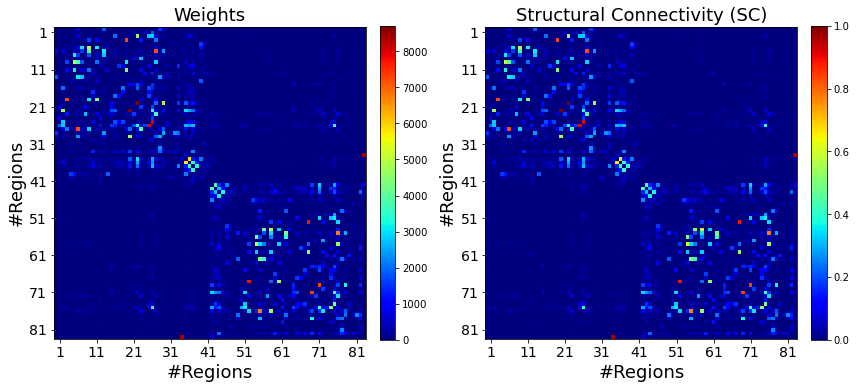

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((weights[0]), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Weights', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
plt.imshow((SCs[0]), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Structural Connectivity (SC)', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SC0.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SC0.eps"), doi=800)
plt.show()

In [12]:
np.percentile(weights.reshape(-1,), [5, 50, 95])

array([  0.,   2., 841.])

In [13]:
np.percentile(SCs.reshape(-1,), [5, 50, 95])

array([0.        , 0.00022107, 0.08583695])

In [14]:
True_SCs_n=(SCs-np.min(SCs))/(np.max(SCs)-np.min(SCs))
True_SCs_n.shape, True_SCs_n.min(), True_SCs_n.max(), 

((100, 84, 84), 0.0, 1.0)

In [15]:
True_SCs_n_avg=np.mean(True_SCs_n, axis=0)
True_SCs_n_avg.shape

(84, 84)

The key trick here is to use an SVD to decompose the real connectomes into a basis set which represent a latent space.  We can encode connectomes into that latent space and decode back into connectome space.  This could be a lot fancier, e.g. a variational autoencoder, a manifold extraction technique etc.  Simpler is better though,

In [16]:
w_ = SCs.reshape((ns, -1))
u, s, vt = np.linalg.svd(w_, full_matrices=False)
u.shape, vt.shape

((100, 100), (100, 7056))

In [17]:
w_.shape

(100, 7056)

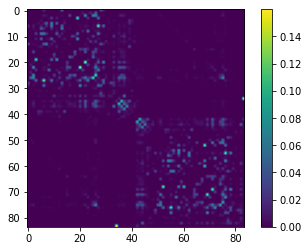

In [18]:
imshow(-vt[0].reshape((nn, nn))), colorbar();

In [19]:
u.T @ s @ vt - w_

array([[ 5.48760246e-14,  5.22454642e-03, -1.02863859e-01, ...,
         8.24216600e-03,  6.26848186e-03,  0.00000000e+00],
       [ 5.48760246e-14,  5.33940973e-03, -1.05438020e-01, ...,
         8.23445024e-03,  6.49820848e-03,  0.00000000e+00],
       [ 5.48760246e-14,  5.33940973e-03, -1.03646562e-01, ...,
         8.35702931e-03,  6.20469513e-03,  0.00000000e+00],
       ...,
       [ 5.48760246e-14,  5.33940973e-03, -1.04290863e-01, ...,
         8.35702931e-03,  5.94936106e-03,  0.00000000e+00],
       [ 5.48760246e-14,  5.33940973e-03, -1.06235025e-01, ...,
         8.35702931e-03,  6.49820848e-03,  0.00000000e+00],
       [ 5.48760246e-14,  5.33940973e-03, -1.03840509e-01, ...,
         8.35702931e-03,  6.23184961e-03,  0.00000000e+00]])

In [20]:
np.allclose(0, u@np.diag(s)@vt - w_)

True

In [21]:
(u@np.diag(s)).shape

(100, 100)

In [22]:
for nc in range(2, 20):
    rSCs = (u[:,:nc] @ np.diag(s[:nc]) @ vt[:nc]).reshape(SCs.shape)
    sim = np.zeros((100, 100))
    nconf = 0
    for i in range(100):
        for j in range(100):
            sim[i,j] = np.sum(np.square(rSCs[i] - SCs[j]))
        nconf  += int(np.argmin(sim[i,:])!=i)
    print('components', nc, 'confusions', nconf)
    if nconf == 0:
        break

components 2 confusions 86
components 3 confusions 78
components 4 confusions 67
components 5 confusions 56
components 6 confusions 43
components 7 confusions 38
components 8 confusions 23
components 9 confusions 15
components 10 confusions 9
components 11 confusions 5
components 12 confusions 3
components 13 confusions 2
components 14 confusions 0


If that seems ok, then `u[:,nc]` is our true connectomes in latent space, and we can plot them in that latent space,

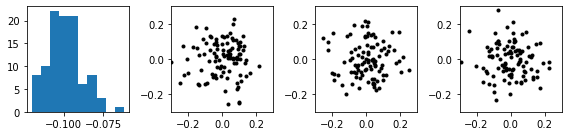

In [23]:
figure(figsize=(8,2))
subplot(1, 4, 1); hist(u[:, 0])
for i in range(3):
    subplot(1, 4, i + 2)
    plot(u[:, i*2+1], u[:, i*2+2], 'k.')
    axis([-0.3, 0.3, -0.3, 0.3])
tight_layout()

From this we can build a multivariate normal,

In [24]:
mu = np.mean(u[:,:nc], axis=0)
cov = np.cov(u[:,:nc].T)
mu.shape, cov.shape

((14,), (14, 14))

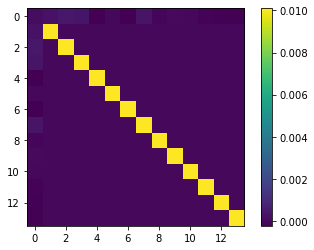

In [25]:
imshow(cov), colorbar();

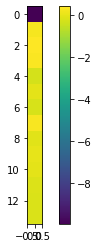

In [26]:
imshow(100*mu.reshape(-1,1)), colorbar();

In [27]:
mu.min(), mu.max()

(-0.09937812810938823, 0.004256923019221633)

In [28]:
mu.min(), mu.max()

(-0.09937812810938823, 0.004256923019221633)

In [29]:
10000*mu

array([-9.93781281e+02,  2.69891750e+01,  4.25692302e+01,  3.64258853e+01,
       -2.25661604e+01,  9.07329344e-01, -2.09537568e+01,  3.11153264e+01,
       -5.76778179e+00,  5.56056042e+00,  1.48810206e+00, -1.10536904e+01,
       -1.54286817e+01, -1.72020698e+01])

and sample from it

In [30]:
dist = multivariate_normal(mean=mu, cov=1*cov)
new_u = dist.rvs(size=(100,))
new_u.shape

(100, 14)

and construct now new connectomes

In [31]:
new_SCs = (new_u @ np.diag(s[:nc]) @ vt[:nc]).reshape(SCs.shape)

In [32]:
new_SCs.shape

(100, 84, 84)

In [33]:
new_SCs.min(), new_SCs.max()

(-0.055766066056926446, 1.3074081872042658)

In [34]:
np.percentile(SCs.reshape(-1,), [5, 50, 95])

array([0.        , 0.00022107, 0.08583695])

In [35]:
np.percentile(new_SCs.reshape(-1,), [5, 50, 95])

array([-3.97121694e-06,  2.98819075e-04,  8.76447292e-02])

In [36]:
new_SCs.min(), new_SCs.max()

(-0.055766066056926446, 1.3074081872042658)

In [37]:
new_SCs_n=(new_SCs-np.min(new_SCs))/(np.max(new_SCs)-np.min(new_SCs))

In [38]:
new_SCs_n.min(), new_SCs_n.max()

(0.0, 1.0)

In [39]:
new_SCs_n_avg=np.mean(new_SCs_n, axis=0)
new_SCs_n_avg.shape

(84, 84)

In [40]:
SCs[0][10,2], new_SCs_n[0][10,2], new_SCs_n_avg[10,2]

(0.00022972662531587412, 0.041562976782016224, 0.04125235374210396)

/home/meysam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "doi" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/meysam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "doi" which is no longer supported as of 3.3 and will become an error two minor releases later


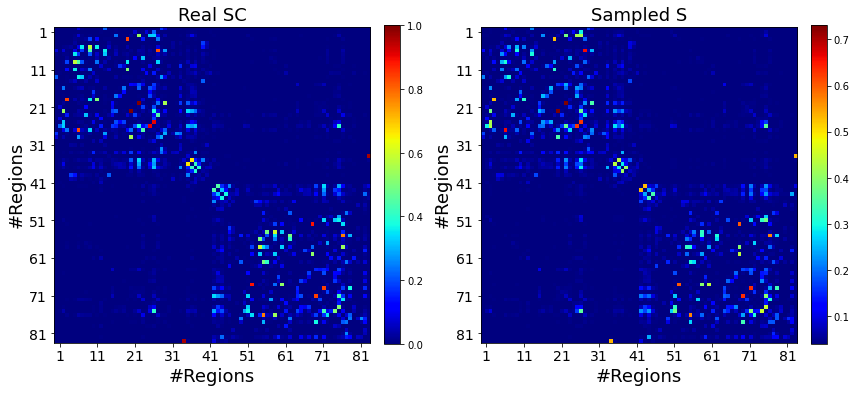

In [41]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((SCs[0]), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Real SC', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
plt.imshow((new_SCs_n[0]), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Sampled S', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"GeneratedSC0.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"GeneratedSC0.eps"), doi=800)
plt.show()

(array([6.712e+03, 1.620e+02, 9.000e+01, 4.000e+01, 1.800e+01, 1.600e+01,
        0.000e+00, 8.000e+00, 8.000e+00, 2.000e+00]),
 array([0.04046035, 0.10943743, 0.17841452, 0.24739161, 0.3163687 ,
        0.38534579, 0.45432287, 0.52329996, 0.59227705, 0.66125414,
        0.73023123]),
 <BarContainer object of 10 artists>)

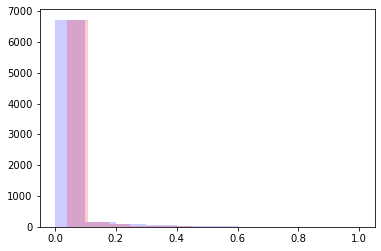

In [42]:
plt.hist(SCs[0].reshape(-1), color='b', alpha=0.2)
plt.hist(new_SCs_n[0].reshape(-1), color='r', alpha=0.2)

/home/meysam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "doi" which is no longer supported as of 3.3 and will become an error two minor releases later
/home/meysam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "doi" which is no longer supported as of 3.3 and will become an error two minor releases later


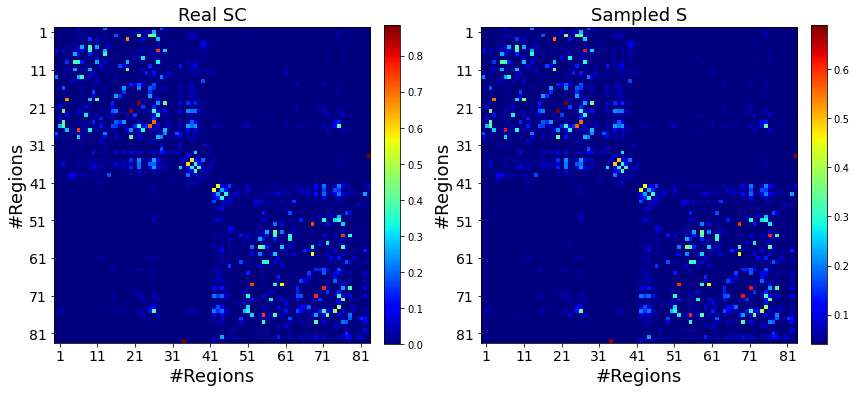

In [43]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow((np.mean(SCs, axis=0)), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Real SC', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.subplot(122)
plt.imshow((new_SCs_n_avg), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Sampled S', fontsize=18)
plt.ylabel('#Regions', fontsize=18.0)
plt.xlabel('#Regions', fontsize=18.0)
plt.xticks(np.r_[1:nn+1][::10], fontsize=14)
plt.yticks(np.r_[1:nn+1][::10], fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"GeneratedSC_avg.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"GeneratedSC_avg.eps"), doi=800)
plt.show()

(array([6.702e+03, 1.680e+02, 7.800e+01, 4.000e+01, 4.200e+01, 4.000e+00,
        6.000e+00, 0.000e+00, 1.200e+01, 4.000e+00]),
 array([0.04090898, 0.10562815, 0.17034731, 0.23506648, 0.29978565,
        0.36450482, 0.42922399, 0.49394316, 0.55866232, 0.62338149,
        0.68810066]),
 <BarContainer object of 10 artists>)

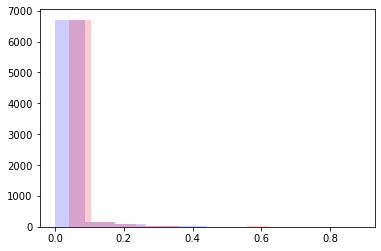

In [44]:
plt.hist(True_SCs_n_avg.reshape(-1), color='b', alpha=0.2)
plt.hist(new_SCs_n_avg.reshape(-1), color='r', alpha=0.2)